In [ ]:
!curl ipinfo.io

{
  "ip": "34.143.232.219",
  "hostname": "219.232.143.34.bc.googleusercontent.com",
  "city": "Singapore",
  "region": "Singapore",
  "country": "SG",
  "loc": "1.2897,103.8501",
  "org": "AS396982 Google LLC",
  "postal": "018989",
  "timezone": "Asia/Singapore",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
!pip install yfinance pmdarima statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 55.8 MB/s eta 0:00:00


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
df_tsla = pd.read_csv(f"{TICKER}.csv")

# gs = yf.download(TICKER, start="2020-01-01", end="2021-01-01")
# df_tsla = yf.download(TICKER, start="2011-01-01", end="2021-01-01")

## 1.3 Split Data into training and testing sets

In [ ]:
# Download TSLA stock data
ticker = yf.Ticker(TICKER)
df = ticker.history(start="2023-01-01", end="2023-08-02")

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Convert 'Date' column to the desired format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Set 'Date' back as index if needed
df.set_index('Date')

# Split the data into training and test sets
train_size = int(len(df['Close']) * 0.8)

train, test = train_test_split(df['Close'], test_size=0.2, shuffle=False)
# train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
train

,Close
0,108.099998
1,113.639999
2,110.339996
3,113.059998
4,119.769997
...,...
111,258.709991
112,256.790009
113,255.899994
114,260.540009


In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,231402800,0.0,0.0
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,180389000,0.0,0.0
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,157986300,0.0,0.0
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,220911100,0.0,0.0
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,190284000,0.0,0.0


In [ ]:
df_tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Open'], df['High'], color='blue', edgecolor='black')
    plt.title('Open vs High')
    plt.xlabel('Open Price')
    plt.ylabel('High Price')
    plt.grid(True)
    plt.show()
    print('done')

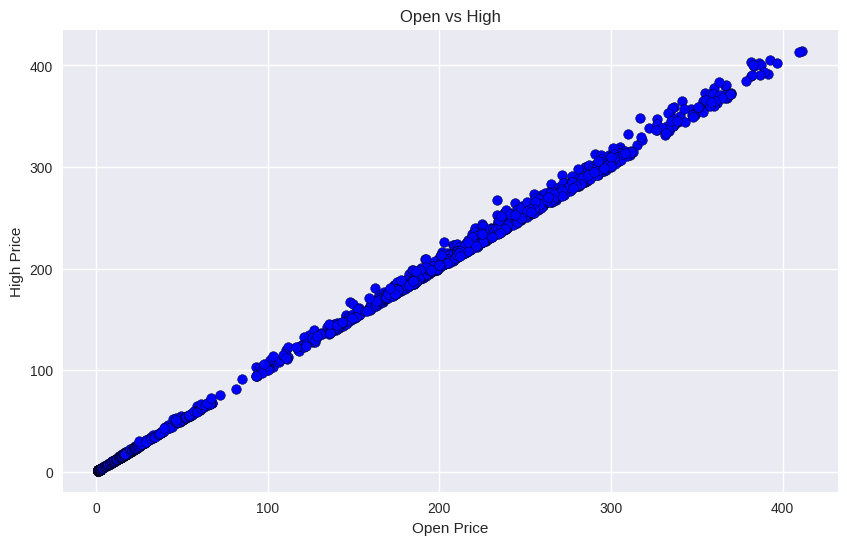

done


In [ ]:
plot_open_vs_high(df_tsla)

# 2. Feature Engineering

In [ ]:
df_tsla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3.544000e+03
mean,75.461458,77.115431,73.702271,75.445748,75.445748,9.699568e+07
std,102.511170,104.788841,100.035797,102.441247,102.441247,7.867922e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,11.516667,11.859000,11.212500,11.562500,11.562500,4.766288e+07
50%,17.463333,17.688333,17.097334,17.454333,17.454333,8.247975e+07
75%,161.144997,165.218327,157.722497,161.269997,161.269997,1.229246e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


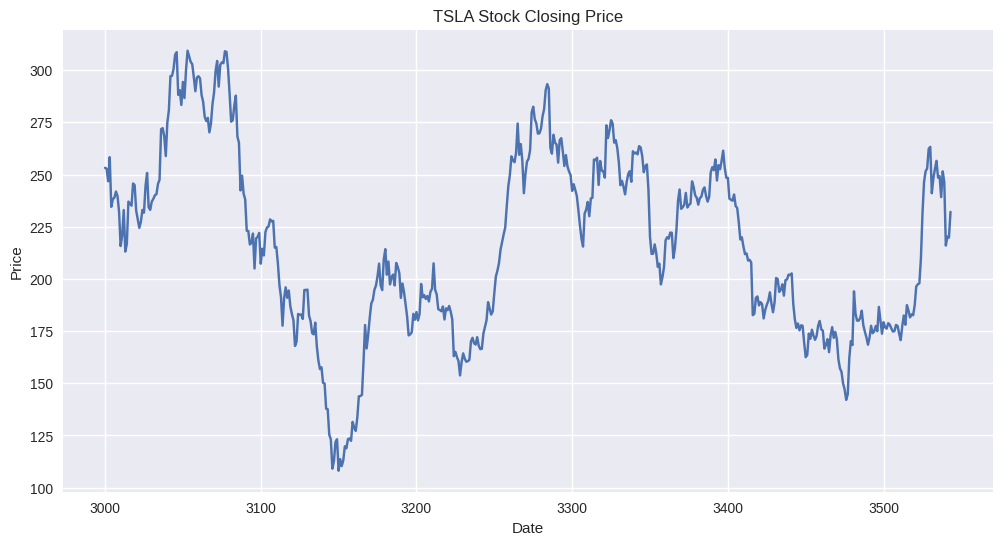

In [ ]:
# Plot the closing price
plt.figure(figsize=(12, 6))
# plt.plot(df_tsla.index, gs['Close'])
plt.plot(df_tsla['Close'][3000:])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## 2.1 Add Extra Features

Text(0.5, 1.0, 'Relative Strength Index (RSI)')

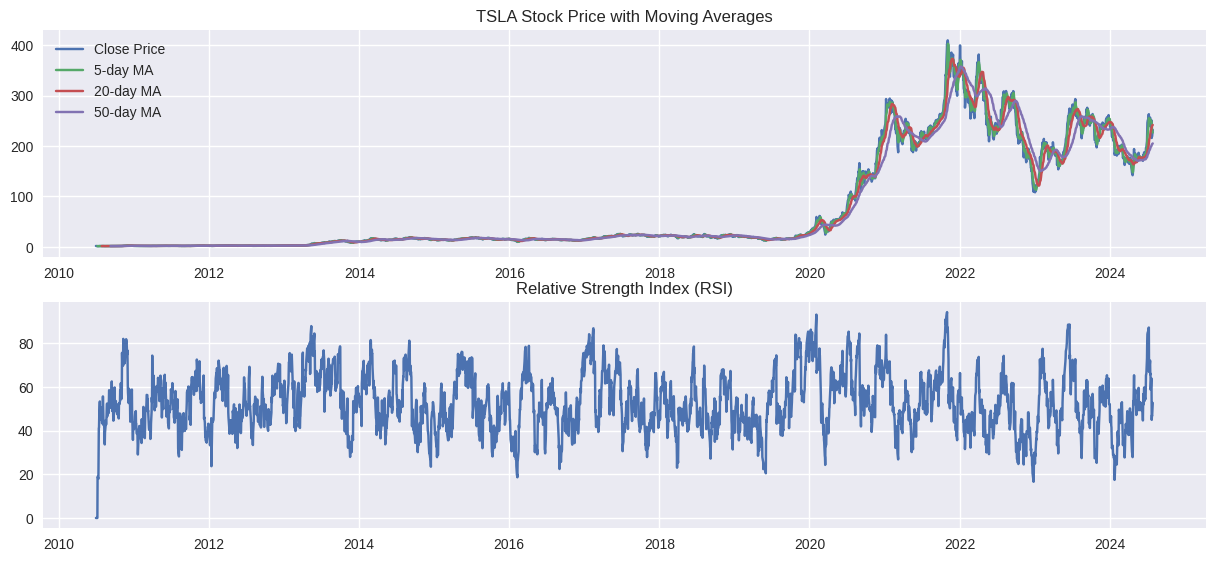

In [ ]:
# Assuming 'Date' is your date column. If it's named differently, replace 'Date' with the actual column name
if 'Date' in df_tsla.columns:
    df_tsla.set_index('Date', inplace=True)
    df_tsla.index = pd.to_datetime(df_tsla.index)
else:
    print("No 'Date' column found. Please ensure your DataFrame has a date column.")
    # You might want to add code here to create a date column if it doesn't exist


# 1. Moving Averages
df_tsla['MA5'] = df_tsla['Close'].rolling(window=5).mean()
df_tsla['MA20'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['MA50'] = df_tsla['Close'].rolling(window=50).mean()

# 2. Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    diff = data.diff()
    up = diff.clip(lower=0)
    down = -1 * diff.clip(upper=0)
    ema_up = up.ewm(com=window - 1, adjust=False).mean()
    ema_down = down.ewm(com=window - 1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

df_tsla['RSI'] = compute_rsi(df_tsla['Close'])

# 3. Bollinger Bands
df_tsla['BB_middle'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['BB_upper'] = df_tsla['BB_middle'] + 2 * df_tsla['Close'].rolling(window=20).std()
df_tsla['BB_lower'] = df_tsla['BB_middle'] - 2 * df_tsla['Close'].rolling(window=20).std()

# 4. Trading Volume Features
df_tsla['Volume_MA5'] = df_tsla['Volume'].rolling(window=5).mean()
df_tsla['Volume_Ratio'] = df_tsla['Volume'] / df_tsla['Volume_MA5']

# 5. Price Momentum
df_tsla['Price_Momentum'] = df_tsla['Close'] - df_tsla['Close'].shift(5)

# 6. Date-based Features
df_tsla['Day_of_Week'] = df_tsla.index.dayofweek
df_tsla['Month'] = df_tsla.index.month
df_tsla['Quarter'] = df_tsla.index.quarter

# Plot some of the engineered features
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_tsla.index, df_tsla['Close'], label='Close Price')
plt.plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
plt.plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
plt.plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
plt.title('TSLA Stock Price with Moving Averages')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_tsla.index, df_tsla['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')

## 2.3 Plot Stock Analysis Charts

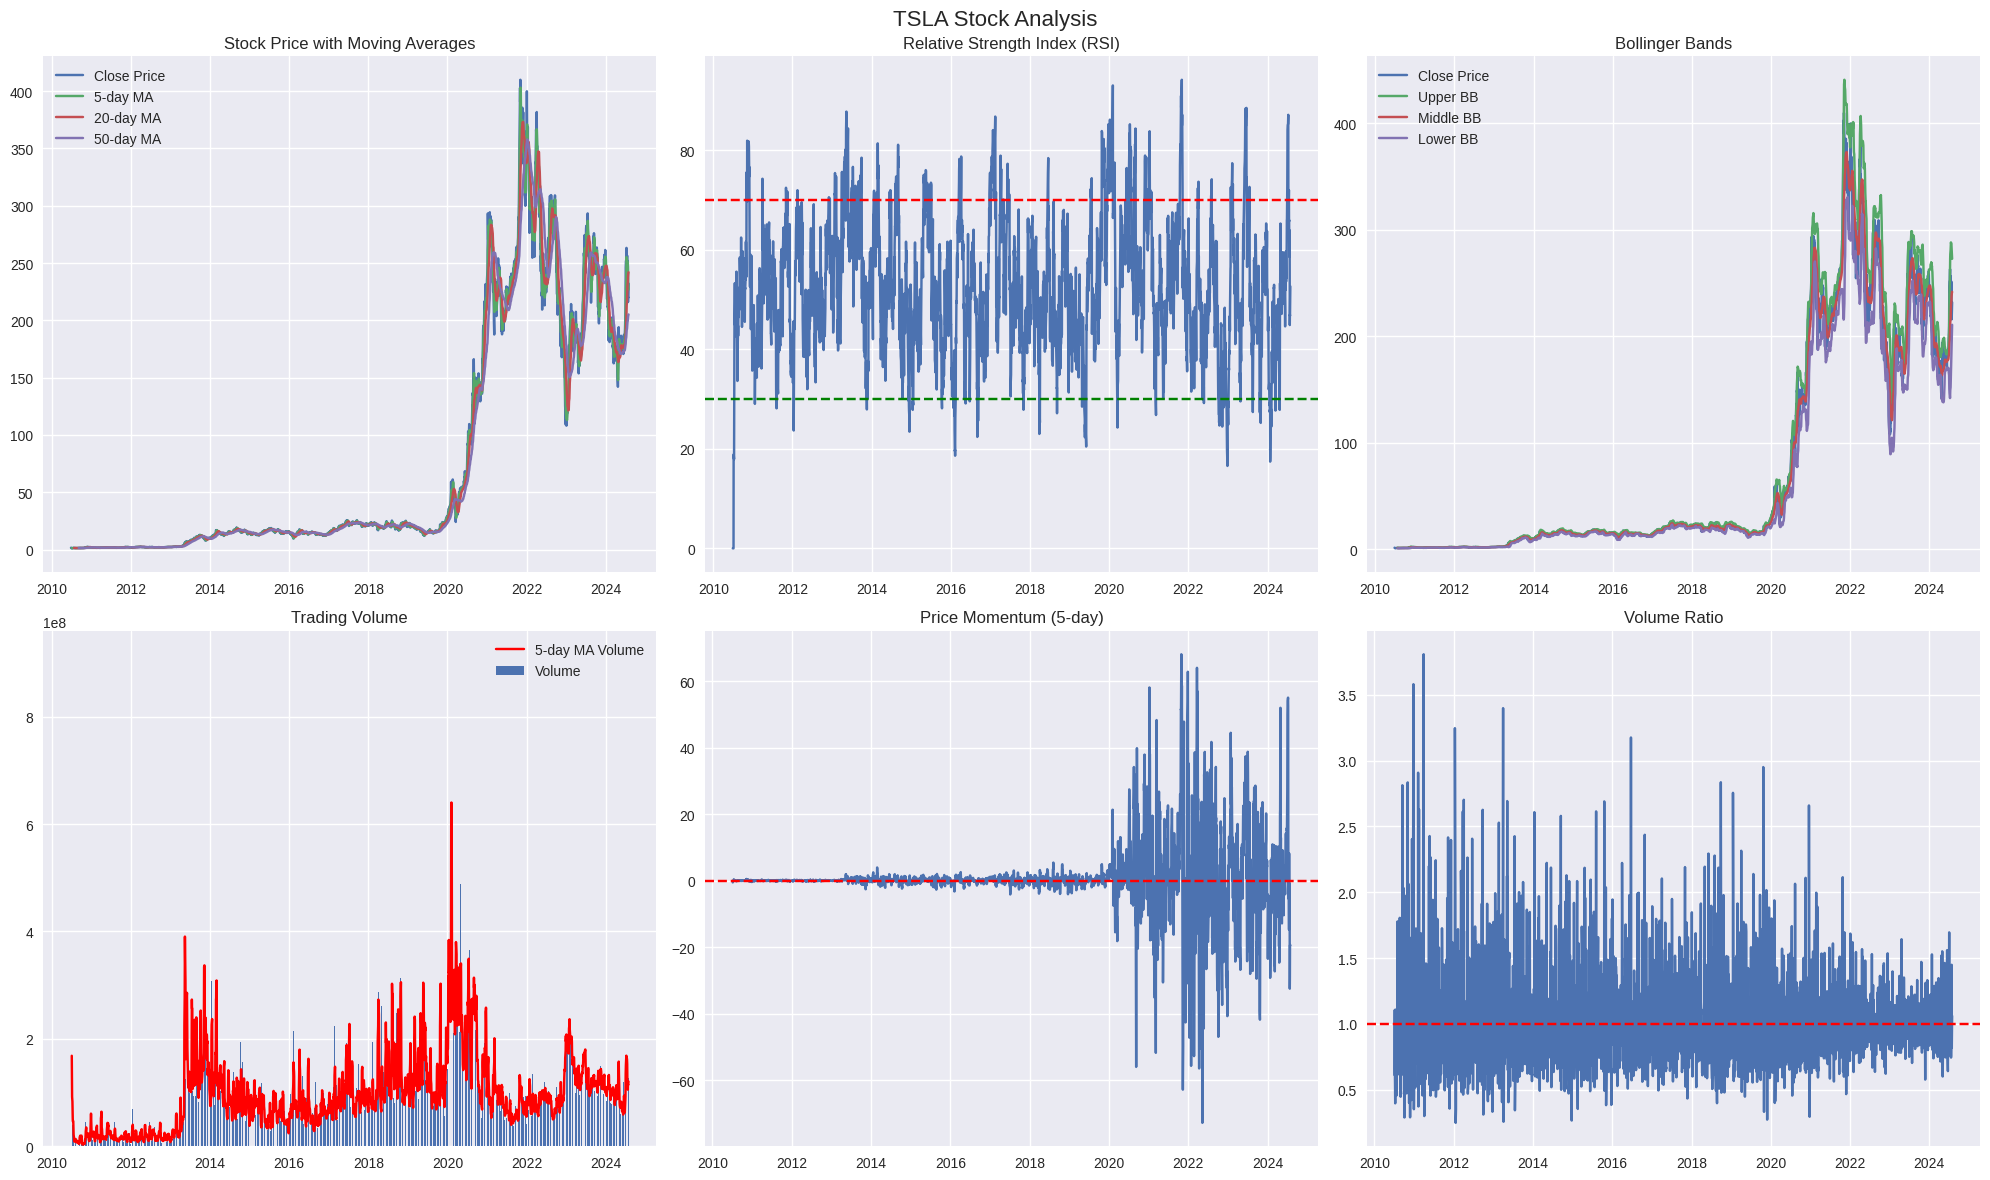

In [ ]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 0].plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df_tsla.index, df_tsla['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_upper'], label='Upper BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_middle'], label='Middle BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df_tsla.index, df_tsla['Volume'], label='Volume')
axs[1, 0].plot(df_tsla.index, df_tsla['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df_tsla.index, df_tsla['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df_tsla.index, df_tsla['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#3. Exploratory Data Analysis

In [ ]:
df_tsla.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
MA5,4
MA20,19
MA50,49
RSI,1


In [ ]:
df_tsla.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
MA5,4
MA20,19
MA50,49
RSI,1


## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

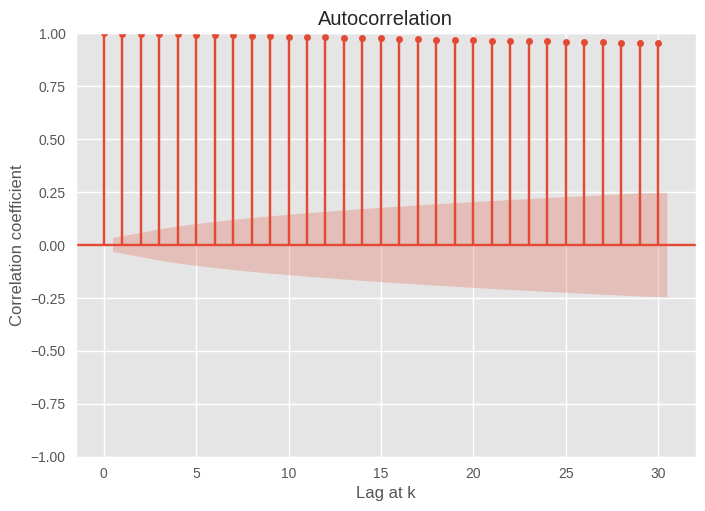

In [ ]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

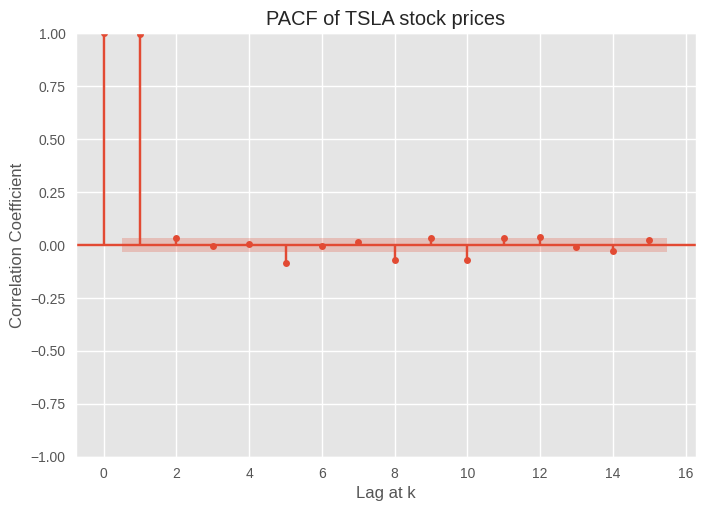

In [ ]:
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_pacf(numerical_data, lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

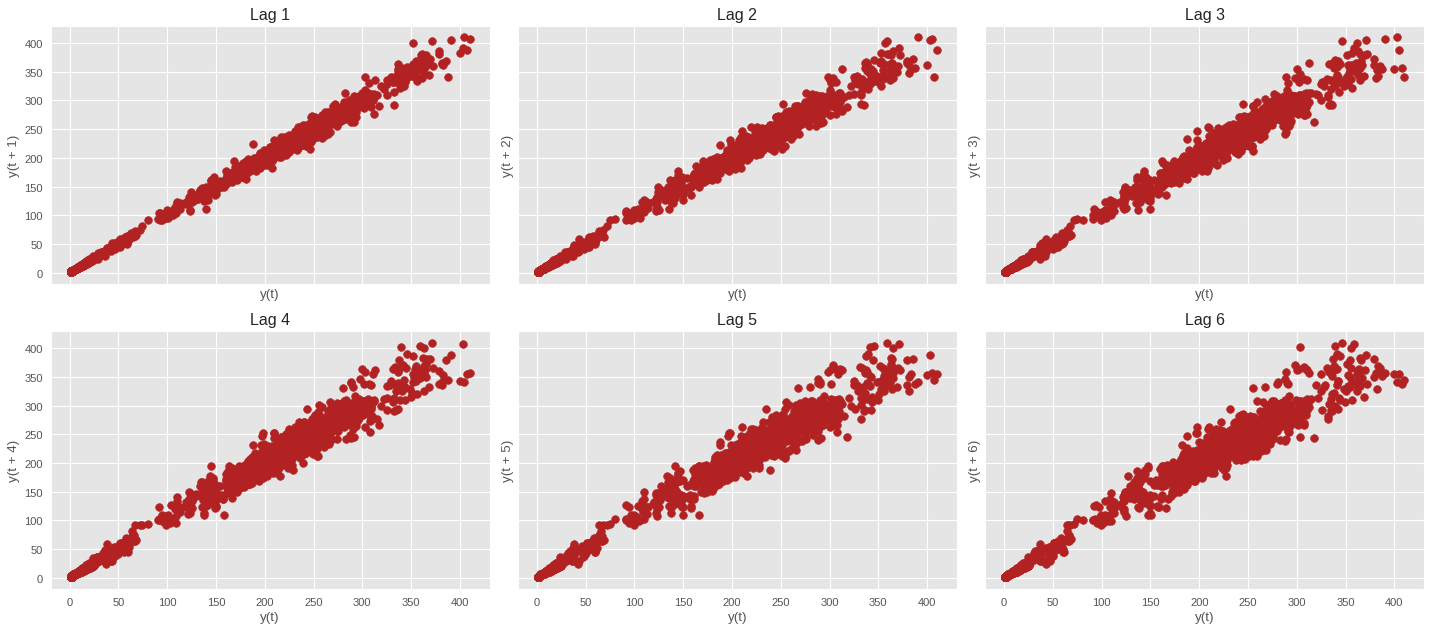

In [ ]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(numerical_data, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

In [ ]:
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA50,RSI,BB_middle,BB_upper,BB_lower,Volume_MA5,Volume_Ratio,Price_Momentum,Day_of_Week,Month,Quarter
Date,,,,,,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3,7,3
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4,7,3
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,1.399867,NaN,NaN,0.0,NaN,NaN,NaN,168536700.0,0.611164,NaN,1,7,3


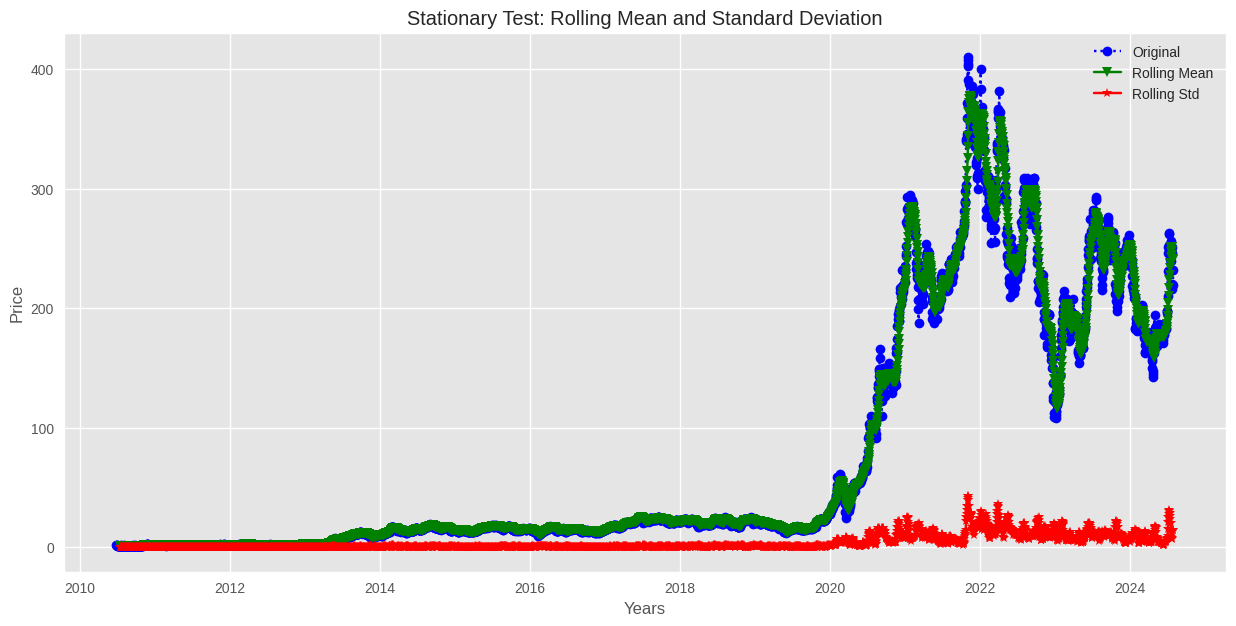

In [ ]:
# Ensure 'Close' is numeric
numerical_data = df_tsla['Close']

# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean = numerical_data.rolling(window=12).mean()
rolling_std = numerical_data.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df_tsla.index, numerical_data, 'b:', marker='o', label='Original')
plt.plot(df_tsla.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df_tsla.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

In [ ]:
def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    df_test = adfuller(time_series)

    print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
    print('{:25s} {:.6f}'.format("\033[1m p-value ", df_test[1]))

    if df_test[0] > df_test[4]["5%"]:
        print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
    else:
        print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

    a = pd.DataFrame([df_test[4]], index=['Critical Values'])
    return a

In [ ]:
# Lets test the stationarity
stationarity_test(df_tsla['Close'])

 ADF Statistic        -1.103908
 p-value              0.713511
Failed to Reject Ho - Time Series is Non-Stationary



,1%,5%,10%
Critical Values,-3.432212,-2.862363,-2.567208


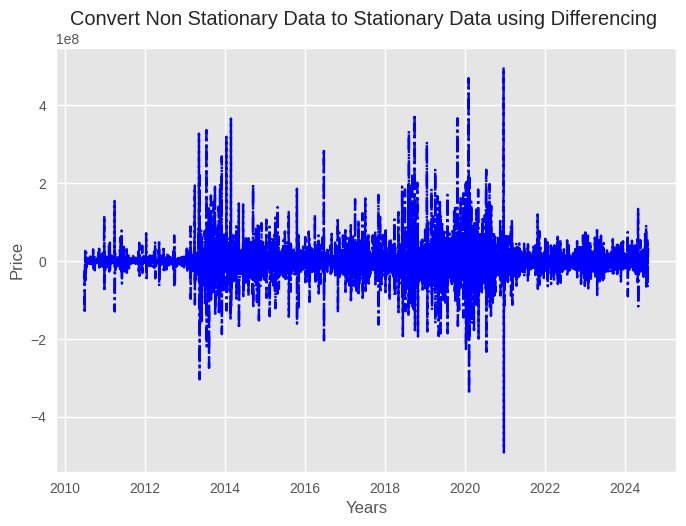

In [ ]:
df_tsla_stock = df_tsla.diff(1).bfill() # First order differencing
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_tsla_stock, 'b-.')

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

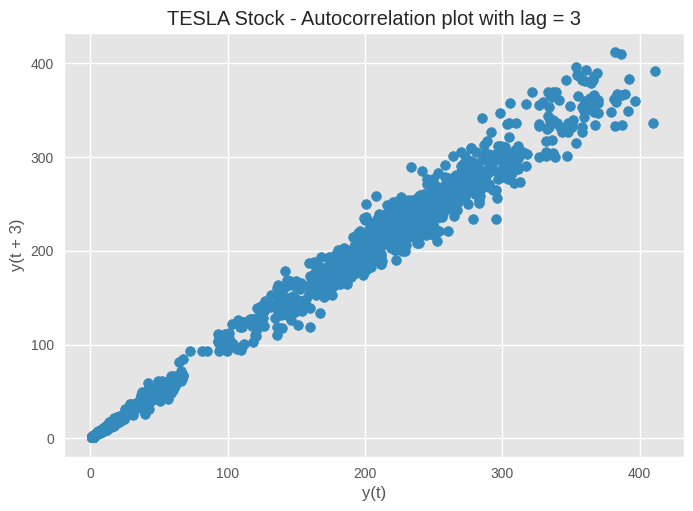

In [ ]:
plt.figure()
lag_plot(df_tsla['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Simple ARIMA

In [ ]:
class ArimaModel:
    def __init__(self, train, test):
        """
        Initializes the ARIMAStockForecast with training and testing datasets.

        Parameters:
        train (pd.Series): The training dataset.
        test (pd.Series): The testing dataset.
        """
        self.train = train
        self.test = test
        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).

        Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

        Returns:
        float: MASE value.
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        errors = np.abs(y_true - y_pred)
        return errors.mean() / d

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).

        Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

        Returns:
        float: SMAPE value.
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.

        Parameters:
        r_squared (float): R-Squared value.
        n (int): Number of observations.
        p (int): Number of predictors.

        Returns:
        float: Adjusted R-Squared value.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.

        Parameters:
        model (ARIMA): The ARIMA model to be evaluated.
        order (tuple): The (p, d, q) order of the model.

        Returns:
        dict: A dictionary containing evaluation metrics.
        """
        results = model.fit()
        forecast = results.forecast(steps=len(self.test))
        mse = mean_squared_error(self.test, forecast)
        mae = mean_absolute_error(self.test, forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100
        smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
        mase = self.mean_absolute_scaled_error(self.test, forecast)
        r_squared = r2_score(self.test, forecast)
        adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
        aic_value = results.aic
        bic_value = results.bic

        return {
            'Order': order,
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic_value,
            'BIC': bic_value
        }

    def grid_search(self):
        """
        Performs a grid search to find the best ARIMA model order.
        Evaluates models based on RMSE and stores the top 5 models.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        evaluated_orders = []

        for param in pdq:
            try:
                model = ARIMA(self.train, order=param)
                evaluation = self.evaluate_model(model, param)
                evaluated_orders.append(evaluation)
                if evaluation['RMSE'] < self.best_rmse:
                    self.best_rmse = evaluation['RMSE']
                    self.best_order = param
            except:
                continue

        self.results_df = pd.DataFrame(evaluated_orders).sort_values(by='MSE').head(5)
        self.results_df.head()

    def fit_best_model(self):
        """
        Fits the best ARIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()
        plt.title(f'Stock Price Forecast (ARIMA Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

In [ ]:
# Initialize and run the forecast
arima_model = ArimaModel(train, test)

In [ ]:
# Run individual steps
arima_model.grid_search()

In [ ]:
arima_model.fit_best_model()

In [ ]:
arima_model.make_forecast()

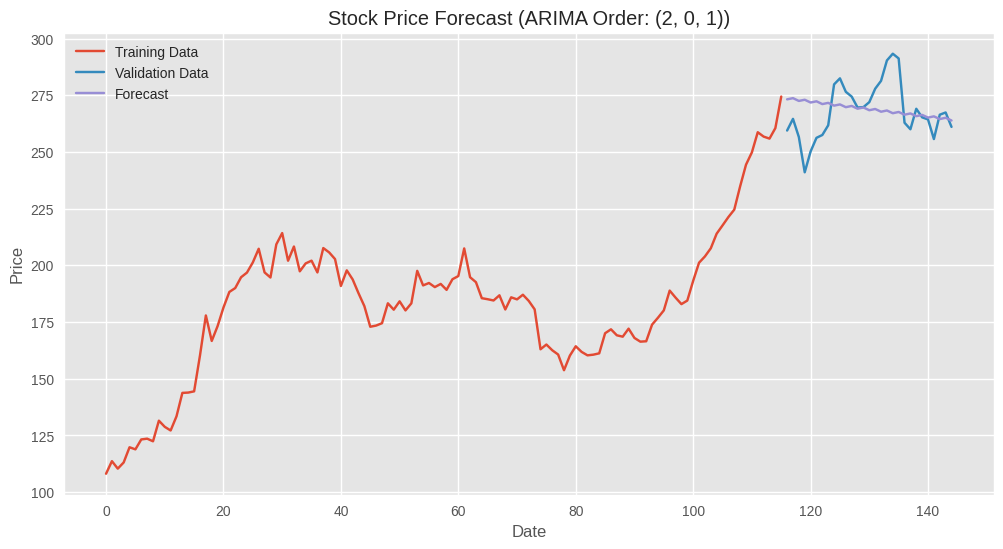

In [ ]:
arima_model.plot_results()

In [ ]:
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 173.9899804456624
Final Mean Absolute Error: 10.183501699340942
Final Root Mean Squared Error: 13.190526162578292


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  116
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -383.096
Date:                Thu, 08 Aug 2024   AIC                            776.193
Time:                        22:06:42   BIC                            789.961
Sample:                             0   HQIC                           781.782
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        188.2116     68.548      2.746      0.006      53.861     322.562
ar.L1         -0.0041      0.050     -0.083      0.934      -0.102       0.093
ar.L2          0.9959      0.041     24.141      0.000

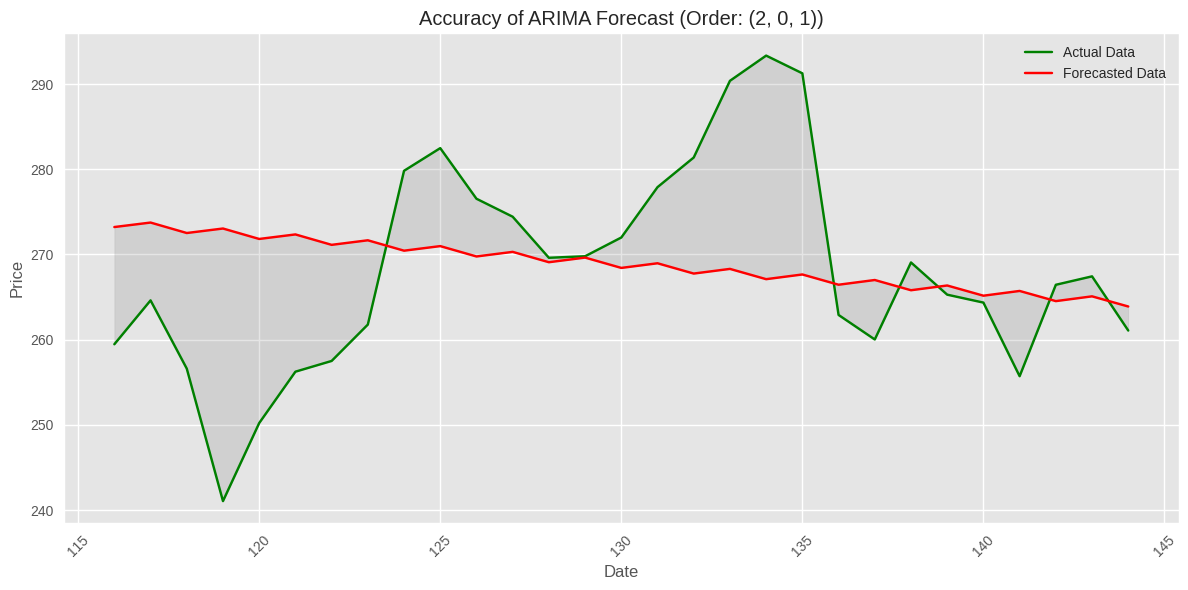

In [ ]:
arima_model.plot_accuracy()

In [ ]:
arima_model.evaluate_model()

NameError: name 'arima_model' is not defined